In [2]:
%load_ext pycodestyle_magic
%flake8_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [3]:
import os
import sys
import random as rand

import cv2
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

# To be used for image and bounding boxes augmentation
import albumentations as A

# Check versions of libraries
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"OpenCV: {cv2.__version__}")

Python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
numpy: 1.19.2
matplotlib: 3.3.2
OpenCV: 4.5.2


In [4]:
CURRENT_DIR = os.getcwd()
TRAINING_SET_DIR = os.path.join(CURRENT_DIR, "images", "training_set")
VALIDATION_SET_DIR = os.path.join(CURRENT_DIR, "images", "validation_set")

IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

In [5]:
def parse_annotations(xml_file: str):
    """https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python"""
    """Parses the annotation file and returns the bounding boxes and breed names"""

    tree = ET.parse(xml_file)
    root = tree.getroot()

    all_bounding_boxes = []

    for boxes in root.iter("object"):
        filename = root.find("object").find("name").text

        xmin, xmax, ymin, ymax = None, None, None, None

        # Finds the bounding box coordinates of the dog within the image
        xmin = int(boxes.find("bndbox/xmin").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        ymin = int(boxes.find("bndbox/ymin").text)
        ymax = int(boxes.find("bndbox/ymax").text)

        bounding_box = [xmin, xmax, ymin, ymax]
        all_bounding_boxes.append(bounding_box)

    return filename, all_bounding_boxes

2:80: E501 line too long (95 > 79 characters)
3:80: E501 line too long (83 > 79 characters)


In [21]:
def load_data(image_set_dir, image_width, image_height):
    """Loads image data and breed names from directory"""

    # Lists for image data and breed names
    image_data = []
    breed_names = []
    bounding_boxes = []

    # Iterates the files as (with the help of sorted()):
    # breedId1_dogId1
    # breedId1_dogId1.jpg
    # breedId1_dogId2
    # breedId1_dogId2.jpg
    # ...
    # breedId120_dogIdX.jpg
    for breed_folder in os.listdir(image_set_dir):
        for file in sorted(os.listdir(os.path.join(image_set_dir, breed_folder))):
            file_path = os.path.join(image_set_dir, breed_folder, file)

            # Checks images to resize and crop according to its bounding box
            if file_path.endswith(".jpg"):
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Crop the image to its bounding box and resize it to standard size
                image = image[bounding_boxes[-1][2]:bounding_boxes[-1][3],
                              bounding_boxes[-1][0]:bounding_boxes[-1][1]]
                
                # TODO: Augment images here, then resize
                # Which library to use for augmenting and which augmentations?
                # augment_images()
                
                # TODO: Resize to standard size by cropping main dog feature or
                # standard image resizing (can produce strange dog images)
                resized_image = cv2.resize(image, (image_width, image_height))
                
                """"""
                # resized_image = augment_images(image, image_width, image_height)
                
                image_data.append(resized_image)

            # Checks annotation files for the dog's breed and its bounding boxes
            else:
                breed_name, bounding_box = parse_annotations(file_path)
                breed_names.append(breed_name)
                bounding_boxes.append(bounding_box[0])

    return image_data, breed_names, bounding_boxes

17:80: E501 line too long (82 > 79 characters)
25:80: E501 line too long (83 > 79 characters)
28:1: W293 blank line contains whitespace
32:1: W293 blank line contains whitespace
39:80: E501 line too long (80 > 79 characters)


In [22]:
image_data_train, breed_names_train, bounding_boxes_train\
    = load_data(TRAINING_SET_DIR, IMAGE_WIDTH, IMAGE_HEIGHT)

image_data_validation, breed_names_validation, bounding_boxes_validation\
    = load_data(VALIDATION_SET_DIR, IMAGE_WIDTH, IMAGE_HEIGHT)

In [14]:
def augment_images(image, image_width, image_height):
    """Works fine if its just the image, can't get it to work with bounding boxes
    Follow this:
    https://albumentations.ai/docs/getting_started/image_augmentation/
    """
    transform = A.Compose([
        A.Resize(width=image_width, height=image_height)
    ])
    
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    return transformed_image

6:1: W293 blank line contains whitespace
13:1: W293 blank line contains whitespace


In [10]:
def augment_everything(image, bounding_boxes, breed_name, image_width, image_height):
    """Can't get this to work, have random errors
    
    Following these:
    https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    """
    transform = A.Compose([
        A.Resize(width=image_width, height=image_height)
    ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))
    
    """
    Note: both bboxes and class_labels expects a nested list since it expects
    multiple bounding boxes in each image even though we only have one
    """
    transformed = transform(image=image, bboxes=[bounding_boxes], class_labels=[breed_name])

    transformed_image = transformed["image"]
    transformed_bounding_boxes = transformed["bboxes"]

    return transformed_image, transformed_bounding_boxes

1:80: E501 line too long (81 > 79 characters)
9:80: E501 line too long (84 > 79 characters)
10:1: W293 blank line contains whitespace
11:80: E501 line too long (92 > 79 characters)


In [11]:
"""Testing data augmentation with the first sample image"""
test_image, test_bbox = augment_everything(image_data_train[0],
                                       bounding_boxes_train[0],
                                       breed_names_train[0],
                                       IMAGE_WIDTH,
                                       IMAGE_HEIGHT)

ValueError: Expected y_min for bbox (0.00641025641025641, 1.0536912751677852, 0.08012820512820513, 1.0838926174496644, 'miniature_poodle') to be in the range [0.0, 1.0], got 1.0536912751677852.

In [24]:
def image_view(images, labels):
    """Displays a 3x3 subplot of randomly selected images"""

    fig, ax = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            # Selects a random image and displays it
            index = rand.randint(0, len(images) - 1)
            ax[i, j].imshow(images[index])

            # Displays the breed's name as the title
            ax[i, j].set_title(f"Breed: {labels[index]}")

    plt.show()

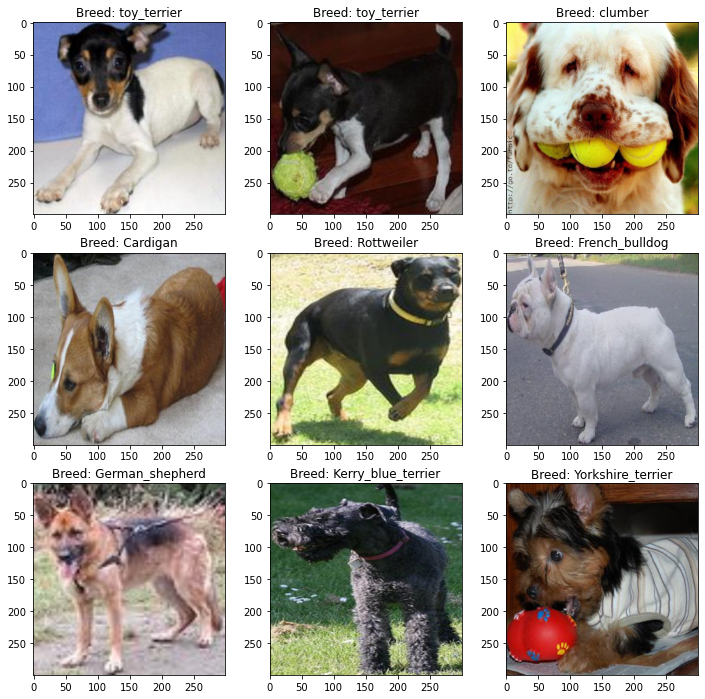

In [25]:
image_view(image_data_train, breed_names_train)